# Demo for processing NIRSpec data from DD-2736 (PI: Pontoppidon)

ERO data of the SMACS-0723 field

In [1]:
import os
os.environ['CRDS_CTX'] = 'jwst_1041.pmap'

import glob
import yaml

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits

import msaexp
from msaexp import pipeline
import grizli.utils


print(f'msaexp version = {msaexp.__version__}')

msaexp version = 0.4.4.dev0+gd19cba8.d20230131


In [2]:
os.getcwd()

'/usr/local/share/python/msaexp/docs/examples'

# Query MAST for NIRSpec data

Query by program name and download `rate.fits` files with `mastquery`.  May need to set `$MAST_TOKEN` environment variable to enable the downloads from MAST.

Can optionally limit the query to specific 

 - gratings:  ``prism``, ``g140m``, ``g235m``, ``g395m``, ``g140m``, ``g235m``, ``g395m``
 - filters:  ``clear``, ``f170lp``, ``f100lp``, ``f170lp``, ``f290lp``
 - detectors: ``nrs1``, ``nrs2``
 
 

In [3]:
# Query NIRSpec data for a program name
masks = pipeline.query_program(2736, download=True, gratings=['g395m']) #, detectors=['nrs2']) #, gratings=['prism'], detectors=['nrs2'])

2023-01-31 16:54:20,230 - stpipe - INFO - MAST API token accepted, welcome Gabriel Brammer


INFO: MAST API token accepted, welcome Gabriel Brammer [astroquery.mast.auth]


In [4]:
masks['filename','program','filter','grating','detector','msametfl'].to_pandas()

,filename,program,filter,grating,detector,msametfl
0,jw02736007001_03103_00001_nrs1_s2d.fits,2736,F290LP,G395M,NRS1,jw02736007001_01_msa.fits
1,jw02736007001_03103_00001_nrs2_s2d.fits,2736,F290LP,G395M,NRS2,jw02736007001_01_msa.fits
2,jw02736007001_03103_00002_nrs1_s2d.fits,2736,F290LP,G395M,NRS1,jw02736007001_01_msa.fits
3,jw02736007001_03103_00002_nrs2_s2d.fits,2736,F290LP,G395M,NRS2,jw02736007001_01_msa.fits
4,jw02736007001_03103_00003_nrs1_s2d.fits,2736,F290LP,G395M,NRS1,jw02736007001_01_msa.fits
5,jw02736007001_03103_00003_nrs2_s2d.fits,2736,F290LP,G395M,NRS2,jw02736007001_01_msa.fits
6,jw02736008001_03103_00001_nrs1_s2d.fits,2736,F290LP,G395M,NRS1,jw02736008001_01_msa.fits
7,jw02736008001_03103_00001_nrs2_s2d.fits,2736,F290LP,G395M,NRS2,jw02736008001_01_msa.fits
8,jw02736008001_03103_00002_nrs1_s2d.fits,2736,F290LP,G395M,NRS1,jw02736008001_01_msa.fits
9,jw02736008001_03103_00002_nrs2_s2d.fits,2736,F290LP,G395M,NRS2,jw02736008001_01_msa.fits


# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

In [5]:
groups = pipeline.exposure_groups()
groups

   N  value     
====  ==========
   3  jw02736007001-01-f290lp-g395m-nrs1
   3  jw02736007001-01-f290lp-g395m-nrs2
   3  jw02736008001-01-f290lp-g395m-nrs1
   3  jw02736008001-01-f290lp-g395m-nrs2


OrderedDict([('jw02736007001-01-f290lp-g395m-nrs1',
              ['jw02736007001_03103_00001_nrs1_rate.fits',
               'jw02736007001_03103_00002_nrs1_rate.fits',
               'jw02736007001_03103_00003_nrs1_rate.fits']),
             ('jw02736007001-01-f290lp-g395m-nrs2',
              ['jw02736007001_03103_00001_nrs2_rate.fits',
               'jw02736007001_03103_00002_nrs2_rate.fits',
               'jw02736007001_03103_00003_nrs2_rate.fits']),
             ('jw02736008001-01-f290lp-g395m-nrs1',
              ['jw02736008001_03103_00001_nrs1_rate.fits',
               'jw02736008001_03103_00002_nrs1_rate.fits',
               'jw02736008001_03103_00003_nrs1_rate.fits']),
             ('jw02736008001-01-f290lp-g395m-nrs2',
              ['jw02736008001_03103_00001_nrs2_rate.fits',
               'jw02736008001_03103_00002_nrs2_rate.fits',
               'jw02736008001_03103_00003_nrs2_rate.fits'])])

## Preprocessing pipeline

1. Run 1/f correction and identify "snowballs" on the `rate.fits` files
2. Remove "bias" (i.e., simple median) of each exposure
3. Run parts of the Level 2 JWST calibration pipeline ([calweb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)):
  - [AssignWcs](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.assign_wcs.AssignWcsStep.html) : initialize WCS and populate slit bounding_box data
  - [Extract2dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html) : identify slits and set slit WCS
  - [FlatFieldStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.flatfield.FlatFieldStep.html#flatfieldstep) : slit-level flat field
  - [PathLossStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pathloss.PathLossStep.html) : NIRSpec path loss
  - [PhotomStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.photom.PhotomStep.html) : Photometric calibration
  
  Note that the `srctype`, `master_background`, `wavecorr` steps are not performed.  The background subtraction is done manually on the 2D slit cutouts.
  
4. Parse slit metadata
5. Save slit cutout files of the last pipeline step performed (`phot` = `PhotomStep`)

Subsequent re-initialization of the `NirspecPipeline` object and `full_pipeline` method will skip these steps and just load the saved slit cutouts.

In [6]:
from importlib import reload
reload(pipeline)

<module 'msaexp.pipeline' from '/Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/msaexp/pipeline.py'>

In [7]:
# Subset of ids
source_ids = [4590, 6355, 10612, 9239, 6113]

for mode in groups:
    if ('02736' in mode) & (not os.path.exists(f'{mode}.slits.yaml')):
        
        # Run the pipeline to define slits, etc., but don't do extractions yet.  
        pipe = pipeline.NirspecPipeline(mode=mode, source_ids=source_ids, pad=1)
        
        # Pipeline steps
        pipe.full_pipeline(run_extractions=False, initialize_bkg=False, run_flag_open=False)
    else:
        print(f'Skip {mode}')

Skip jw02736007001-01-f290lp-g395m-nrs1
Skip jw02736007001-01-f290lp-g395m-nrs2
Skip jw02736008001-01-f290lp-g395m-nrs1
Skip jw02736008001-01-f290lp-g395m-nrs2


In [8]:
files = glob.glob('*2736*slits.yaml')
files.sort()

all_targets = []
skip = []
for file in files:
    with open(file) as fp:
        slits = yaml.load(fp, Loader=yaml.Loader)
        for k in slits:
            if k.startswith('2736_') & ('m' not in k):
                all_targets.append(k)
            elif k not in skip:
                #print(f'skip {k}')
                skip.append(k)

un = grizli.utils.Unique(all_targets)
targets = un.values
print(len(targets))
#targets

   N  value     
====  ==========
   4  2736_10612
   4  2736_4590 
   4  2736_6113 
   4  2736_6355 
   4  2736_9239 
5


In [9]:
from importlib import reload
from msaexp import pipeline
reload(pipeline)
print(pipeline.__file__)

targets = ['2736_4590', '2736_6113']

# # Reinitialize pipeline objects
targets = ['2736_4590', '2736_6355', '2736_10612', '2736_9239', '2736_6113']
#            '2736_8717', '2736_8506', '2736_8498', '2736_3042'][:3]

gratings = {}
for mode in groups:
    if os.path.exists(f'{mode}.slits.yaml') & ('02736' in mode):
        # Run the pipeline to define slits, etc., but don't do extractions yet.  
        obj = pipeline.NirspecPipeline(mode=mode)
        obj.full_pipeline(run_extractions=False, targets=targets)
        
        if obj.grating not in gratings:
            gratings[obj.grating] = []
        
        gratings[obj.grating].append(obj)

/Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/msaexp/pipeline.py
# (2023-01-31 15:54:20.473)
msaexp.NirspecPipeline: Initialize jw02736007001-01-f290lp-g395m-nrs1
msaexp.NirspecPipeline: jw02736007001_03103_00001_nrs1_rate.fits
msaexp.NirspecPipeline: jw02736007001_03103_00002_nrs1_rate.fits
msaexp.NirspecPipeline: jw02736007001_03103_00003_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02736007001-01-f290lp-g395m-nrs1 msametfl=jw02736007001_01_msa.fits
msaexp.read_data: jw02736007001_03103_00001_nrs1_phot.000.2736_9239.fits 2736_9239
msaexp.read_data: jw02736007001_03103_00001_nrs1_phot.001.2736_10612.fits 2736_10612
msaexp.read_data: jw02736007001_03103_00001_nrs1_phot.002.2736_6113.fits background_70
msaexp.read_data: jw02736007001_03103_00001_nrs1_phot.003.2736_6355.fits 2736_6355
msaexp.read_data: jw02736007001_03103_00001_nrs1_phot.004.2736_4590.fits 2736_4590
msaexp.read_data: jw02736007001_03103_00002_nrs1_phot.000.2736_9239.fits 2736_9239
msaexp.read_data: 

msaexp.read_data: jw02736008001_03103_00001_nrs1_phot.003.2736_6355.fits 2736_6355
msaexp.read_data: jw02736008001_03103_00001_nrs1_phot.004.2736_4590.fits 2736_4590
msaexp.read_data: jw02736008001_03103_00002_nrs1_phot.000.2736_9239.fits 2736_9239
msaexp.read_data: jw02736008001_03103_00002_nrs1_phot.001.2736_10612.fits 2736_10612
msaexp.read_data: jw02736008001_03103_00002_nrs1_phot.002.2736_6113.fits background_70
msaexp.read_data: jw02736008001_03103_00002_nrs1_phot.003.2736_6355.fits 2736_6355
msaexp.read_data: jw02736008001_03103_00002_nrs1_phot.004.2736_4590.fits 2736_4590
msaexp.read_data: jw02736008001_03103_00003_nrs1_phot.000.2736_9239.fits 2736_9239
msaexp.read_data: jw02736008001_03103_00003_nrs1_phot.001.2736_10612.fits 2736_10612
msaexp.read_data: jw02736008001_03103_00003_nrs1_phot.002.2736_6113.fits 2736_6113
msaexp.read_data: jw02736008001_03103_00003_nrs1_phot.003.2736_6355.fits 2736_6355
msaexp.read_data: jw02736008001_03103_00003_nrs1_phot.004.2736_4590.fits 2736_4

In [10]:
# Have to run `extract_spectrum` for background subtraction
for key in targets:
    for g in gratings:
        for pipe in gratings[g]:
            print(pipe.mode, key)
            try:
                _ = pipe.extract_spectrum(key, yoffset=0.0, fit_profile_params=None)
                plt.close('all')
            except:
                print('    failed! ')
                plt.close('all')
                continue

2023-01-31 16:55:23,383 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/msaexp/pipeline.py:1217: RuntimeWarning: All-NaN slice encountered
  pscl = np.nanmax(_running[1])



jw02736007001-01-f290lp-g395m-nrs1 2736_4590
jw02736007001-01-f290lp-g395m-nrs2 2736_4590
jw02736008001-01-f290lp-g395m-nrs1 2736_4590
jw02736008001-01-f290lp-g395m-nrs2 2736_4590
jw02736007001-01-f290lp-g395m-nrs1 2736_6355
jw02736007001-01-f290lp-g395m-nrs2 2736_6355
jw02736008001-01-f290lp-g395m-nrs1 2736_6355
jw02736008001-01-f290lp-g395m-nrs2 2736_6355
jw02736007001-01-f290lp-g395m-nrs1 2736_10612
jw02736007001-01-f290lp-g395m-nrs2 2736_10612
jw02736008001-01-f290lp-g395m-nrs1 2736_10612
jw02736008001-01-f290lp-g395m-nrs2 2736_10612
jw02736007001-01-f290lp-g395m-nrs1 2736_9239
jw02736007001-01-f290lp-g395m-nrs2 2736_9239
jw02736008001-01-f290lp-g395m-nrs1 2736_9239
jw02736008001-01-f290lp-g395m-nrs2 2736_9239
jw02736007001-01-f290lp-g395m-nrs1 2736_6113
jw02736007001-01-f290lp-g395m-nrs2 2736_6113
jw02736008001-01-f290lp-g395m-nrs1 2736_6113
jw02736008001-01-f290lp-g395m-nrs2 2736_6113


In [11]:
reload(msaexp.utils)

drizzle_params = {'output':None, 'single':True,
 'pixfrac': 1.0,
 'kernel': 'square',
 'fillval': 0,
 'wht_type': 'ivm',
 'good_bits': 0,
 'pscale_ratio': 1.0,
 'pscale': None}

# Wavelength oversampling relative to grating default
scale = 1.5

# pipes[g].targets


In [12]:
for g in gratings:
    for pipe in gratings[g]:
        print(g, pipe.mode)

f290lp-g395m jw02736007001-01-f290lp-g395m-nrs1
f290lp-g395m jw02736007001-01-f290lp-g395m-nrs2
f290lp-g395m jw02736008001-01-f290lp-g395m-nrs1
f290lp-g395m jw02736008001-01-f290lp-g395m-nrs2


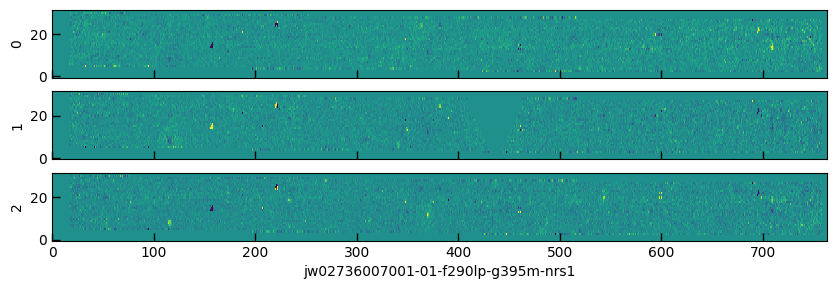

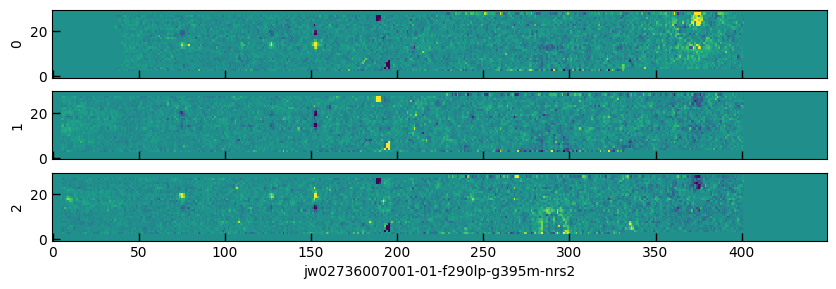

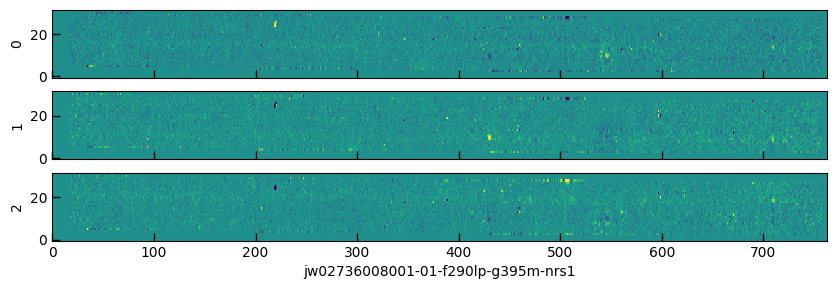

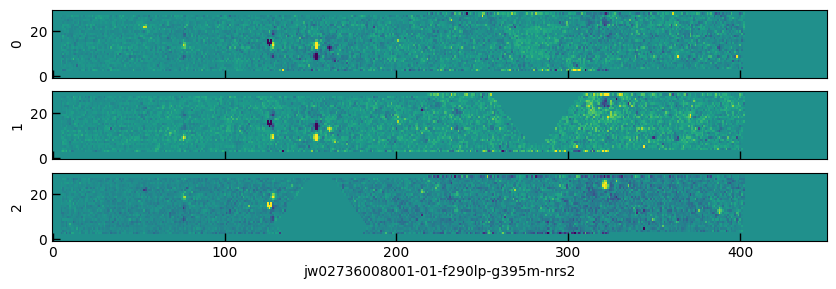

In [13]:
# Look at individual slit cutouts
key = '2736_4590'

hdus = {}
for g in gratings:
    for pipe in gratings[g]:
        _slits = pipe.get_background_slits(key)
        
        fig, axes = plt.subplots(len(_slits), 1, sharex=True, sharey=True, figsize=(10, 3))
        rms = None
        for i, slit in enumerate(_slits):    
            bkg = 0.
            dq = (slit.dq & 1) == 0
            if rms is None:
                rms = grizli.utils.nmad((slit.data - bkg)[dq])
            axes[i].imshow((slit.data - bkg)*dq, vmin=-10*rms, vmax=10*rms, aspect='auto')
            axes[i].set_ylabel(i)
            
        axes[i].set_xlabel(pipe.mode)

In [14]:
# Drizzle combinations

reload(msaexp.utils)

key = '2736_4590'

hdus = {}
for g in gratings:
    slits = []
    for pipe in gratings[g]:
        _slits = pipe.get_background_slits(key)
        
        # Stuck closed in jw02736007001-01-f290lp-g395m-nrs2 4590??
        if ('jw02736007001-01-f290lp-g395m' in pipe.mode) & (key == '2736_4590'):
            _p = _slits.pop(1)
            
        if _slits is not None:
            print(f'Add {len(_slits)} slitlets from {pipe.mode}')
            slits.extend(_slits)
            
    print(f'{g} total {len(slits)} slitlets')
    
    output_root = f'smacs0723-{g}_{key}_v3'

    hdus[g] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                        #profile_slice=slice(int(200*scale), int(600*scale)),
                                        #profile_slice=slice(int(100*scale), int(700*scale)),
                                               profile_slice=None,
                                        standard_waves=scale,
                                        outlier_threshold=5,
                                        output_root=output_root,
                                        fit_prf=True, prf_center=-1., prf_sigma=1.19)

Add 2 slitlets from jw02736007001-01-f290lp-g395m-nrs1
Add 2 slitlets from jw02736007001-01-f290lp-g395m-nrs2
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs1
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs2
f290lp-g395m total 10 slitlets
build_regular_wavelength_wcs: Set user-defined wavelength grid (size=2020)
Pad 2 pixels on 2D cutout


2023-01-31 16:55:31,016 - stpipe - INFO - Driz parameter kernal: square
2023-01-31 16:55:31,016 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-01-31 16:55:31,017 - stpipe - INFO - Driz parameter fillval: 0
2023-01-31 16:55:31,017 - stpipe - INFO - Driz parameter weight_type: ivm
2023-01-31 16:55:31,405 - stpipe - INFO - Resampling science data
2023-01-31 16:55:31,435 - stpipe - INFO - Drizzling (32, 764) --> (43, 2020)
2023-01-31 16:55:31,443 - stpipe - INFO - Resampling var_rnoise
2023-01-31 16:55:31,475 - stpipe - INFO - Drizzling (32, 764) --> (43, 2020)
2023-01-31 16:55:31,484 - stpipe - INFO - Resampling var_poisson
2023-01-31 16:55:31,516 - stpipe - INFO - Drizzling (32, 764) --> (43, 2020)
2023-01-31 16:55:31,525 - stpipe - INFO - Resampling var_flat
2023-01-31 16:55:31,556 - stpipe - INFO - Drizzling (32, 764) --> (43, 2020)
2023-01-31 16:55:31,787 - stpipe - INFO - Resampling science data
2023-01-31 16:55:31,821 - stpipe - INFO - Drizzling (32, 764) --> (43, 2020)
2023-01-

fit_prf: center = -0.39. sigma = 1.01


In [15]:
print(g)
hdus[g].info()

f290lp-g395m
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU     31   2020R x 3C   ['D', 'D', 'D']   
  2  SCI           1 ImageHDU        34   (2020, 43)   float32   
  3  WHT           1 ImageHDU        34   (2020, 43)   float32   
  4  PROFILE       1 ImageHDU        34   (2020, 43)   float64   
  5  PROF1D        1 BinTableHDU     21   43R x 3C   ['D', 'E', 'D']   


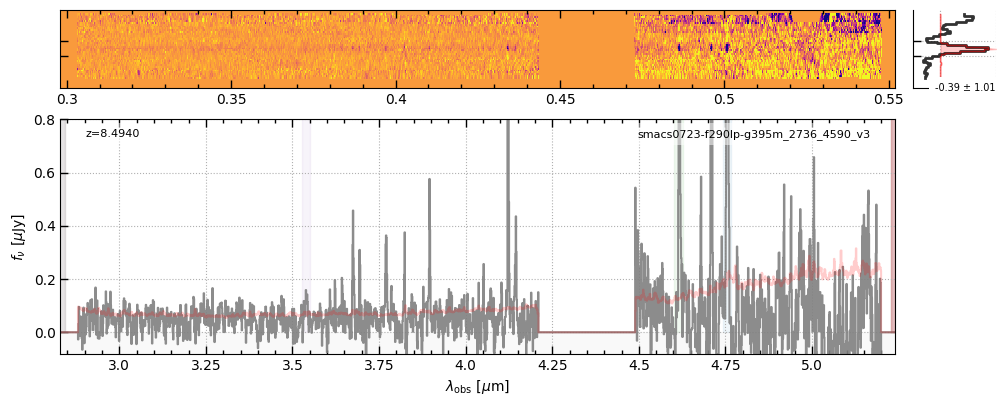

In [16]:
reload(msaexp.utils)
for g in hdus:
    output_root = f'smacs0723-{g}_{key}_v3'
    hdul = hdus[g]
    fig = msaexp.utils.drizzled_hdu_figure(hdul, output_root=output_root, z=8.494, ny=None, ymax=0.8)

    fig.savefig(f'{output_root}.pdf')


Add 2 slitlets from jw02736007001-01-f290lp-g395m-nrs1
Add 2 slitlets from jw02736007001-01-f290lp-g395m-nrs2
smacs0723-007-f290lp-g395m_2736_4590_v3 total 4 slitlets
build_regular_wavelength_wcs: Set user-defined wavelength grid (size=2020)
Pad 2 pixels on 2D cutout


2023-01-31 16:55:36,335 - stpipe - INFO - Driz parameter kernal: square
2023-01-31 16:55:36,335 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-01-31 16:55:36,336 - stpipe - INFO - Driz parameter fillval: 0
2023-01-31 16:55:36,336 - stpipe - INFO - Driz parameter weight_type: ivm
2023-01-31 16:55:36,725 - stpipe - INFO - Resampling science data
2023-01-31 16:55:36,757 - stpipe - INFO - Drizzling (32, 764) --> (38, 2020)
2023-01-31 16:55:36,765 - stpipe - INFO - Resampling var_rnoise
2023-01-31 16:55:36,798 - stpipe - INFO - Drizzling (32, 764) --> (38, 2020)
2023-01-31 16:55:36,807 - stpipe - INFO - Resampling var_poisson
2023-01-31 16:55:36,839 - stpipe - INFO - Drizzling (32, 764) --> (38, 2020)
2023-01-31 16:55:36,848 - stpipe - INFO - Resampling var_flat
2023-01-31 16:55:36,880 - stpipe - INFO - Drizzling (32, 764) --> (38, 2020)
2023-01-31 16:55:37,111 - stpipe - INFO - Resampling science data
2023-01-31 16:55:37,143 - stpipe - INFO - Drizzling (32, 764) --> (38, 2020)
2023-01-

fit_prf: center = -0.55. sigma = 1.00
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs1
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs2
smacs0723-008-f290lp-g395m_2736_4590_v3 total 6 slitlets
build_regular_wavelength_wcs: Set user-defined wavelength grid (size=2020)
Pad 2 pixels on 2D cutout


2023-01-31 16:55:38,712 - stpipe - INFO - Driz parameter kernal: square
2023-01-31 16:55:38,712 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-01-31 16:55:38,712 - stpipe - INFO - Driz parameter fillval: 0
2023-01-31 16:55:38,713 - stpipe - INFO - Driz parameter weight_type: ivm
2023-01-31 16:55:39,104 - stpipe - INFO - Resampling science data
2023-01-31 16:55:39,134 - stpipe - INFO - Drizzling (32, 763) --> (43, 2020)
2023-01-31 16:55:39,142 - stpipe - INFO - Resampling var_rnoise
2023-01-31 16:55:39,175 - stpipe - INFO - Drizzling (32, 763) --> (43, 2020)
2023-01-31 16:55:39,184 - stpipe - INFO - Resampling var_poisson
2023-01-31 16:55:39,218 - stpipe - INFO - Drizzling (32, 763) --> (43, 2020)
2023-01-31 16:55:39,227 - stpipe - INFO - Resampling var_flat
2023-01-31 16:55:39,259 - stpipe - INFO - Drizzling (32, 763) --> (43, 2020)
2023-01-31 16:55:39,489 - stpipe - INFO - Resampling science data
2023-01-31 16:55:39,520 - stpipe - INFO - Drizzling (32, 763) --> (43, 2020)
2023-01-

fit_prf: center = -0.46. sigma = 1.00


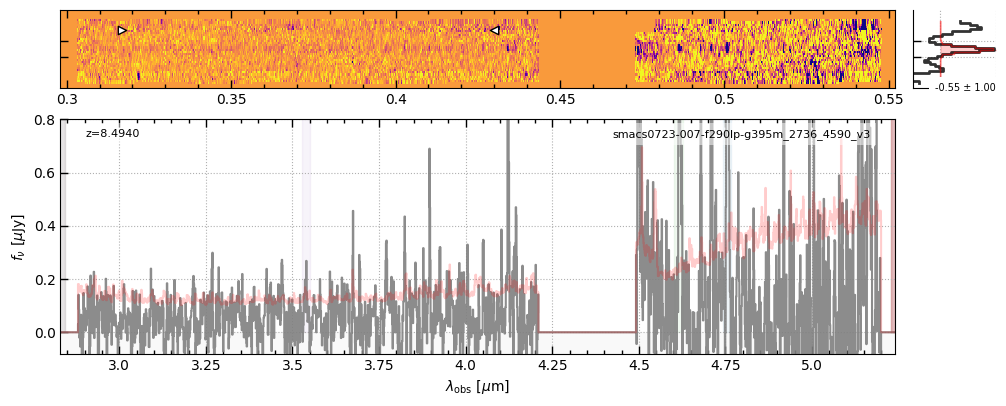

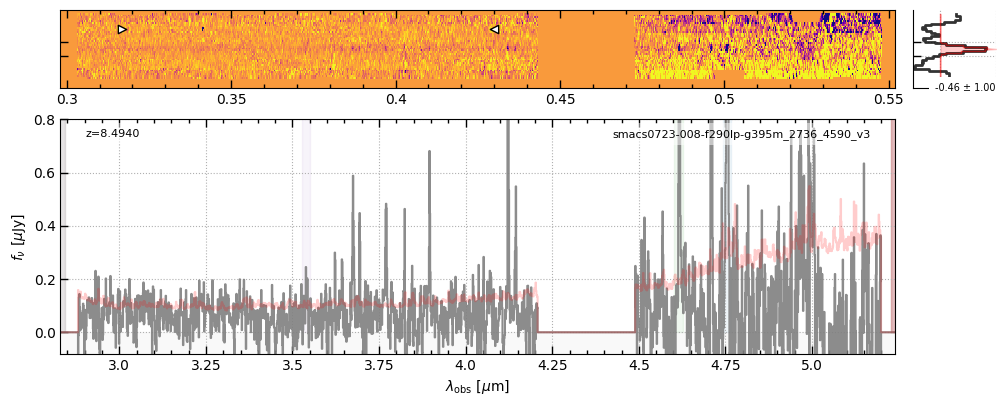

In [17]:
# Drizzle the two visits separately
reload(msaexp.utils)

key = '2736_4590'

ehdus = {}

for exp in ['007','008']:
    for g in gratings:
        slits = []
        for pipe in gratings[g]:
            if f'2736{exp}' not in pipe.mode:
                continue

            _slits = pipe.get_background_slits(key)
            # Stuck closed in jw02736007001-01-f290lp-g395m-nrs2 4590??
            if ('jw02736007001-01-f290lp-g395m' in pipe.mode) & (key == '2736_4590'):
                _p = _slits.pop(1)

            
            if _slits is not None:
                print(f'Add {len(_slits)} slitlets from {pipe.mode}')
                slits.extend(_slits)

        output_root = f'smacs0723-{exp}-{g}_{key}_v3'
        
        print(f'{output_root} total {len(slits)} slitlets')

        ehdus[output_root] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                            #profile_slice=slice(int(200*scale), int(600*scale)),
                                            profile_slice=slice(int(100*scale), int(700*scale)),
                                            standard_waves=scale,
                                            outlier_threshold=5,
                                            output_root=output_root,
                                            fit_prf=True, prf_center=-1.36, prf_sigma=1.0, fix_sigma=True)

        hdul = ehdus[output_root]
        fig = msaexp.utils.drizzled_hdu_figure(hdul, output_root=output_root, z=8.494, ny=None, ymax=0.8)

        fig.savefig(f'{output_root}.pdf')


(-0.2, 2.0)

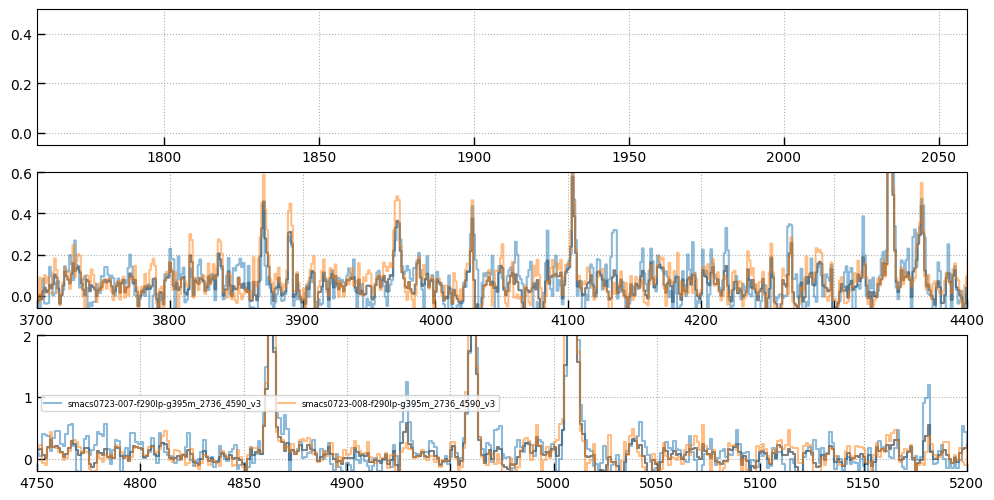

In [18]:
# Compare separate visits
import grizli.utils
fig, axes = plt.subplots(3,1,figsize=(12,6))

for ax in axes:
    for k in hdus:
        sp = grizli.utils.GTable(hdus[k]['SPEC1D'].data)
        ax.step(sp['wave']*1.e4/(1+8.494), sp['flux'], where='mid', alpha=0.5, color='k')

    for k in ehdus:
        sp = grizli.utils.GTable(ehdus[k]['SPEC1D'].data)
        ax.step(sp['wave']*1.e4/(1+8.494), sp['flux'], where='mid', alpha=0.5, label=k)

    ax.grid()

ax.legend(ncol=2, fontsize=6)

ax = axes[0]; ax.set_xlim(1909-150, 1909+150); ax.set_ylim(-0.05,0.5)
ax = axes[1]; ax.set_xlim(3700, 4400); ax.set_ylim(-0.03*2,0.3*2)
ax = axes[2]; ax.set_xlim(4750, 5200); ax.set_ylim(-0.1*2,1*2)


In [19]:
# Drizzle combinations
key = '2736_6355'

reload(msaexp.utils)

hdus = {}
for g in gratings:
    slits = []
    for pipe in gratings[g]:
        _slits = pipe.get_background_slits(key)
        if _slits is not None:
            slits.extend(_slits)
            
    print(g, len(slits))
    
    output_root = f'smacs0723-{g}_{key}_v3'

    hdus[g] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                        profile_slice=slice(int(200*scale), int(600*scale)),
                                        standard_waves=scale,
                                        outlier_threshold=10,
                                               ypad=2,
                                        output_root=output_root,
                                        fit_prf=True, prf_center=None, prf_sigma=0.9)    

f290lp-g395m 12
build_regular_wavelength_wcs: Set user-defined wavelength grid (size=2020)
Pad 2 pixels on 2D cutout


2023-01-31 16:55:43,629 - stpipe - INFO - Driz parameter kernal: square
2023-01-31 16:55:43,630 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-01-31 16:55:43,630 - stpipe - INFO - Driz parameter fillval: 0
2023-01-31 16:55:43,630 - stpipe - INFO - Driz parameter weight_type: ivm
2023-01-31 16:55:44,019 - stpipe - INFO - Resampling science data
2023-01-31 16:55:44,073 - stpipe - INFO - Drizzling (45, 1034) --> (57, 2020)
2023-01-31 16:55:44,093 - stpipe - INFO - Resampling var_rnoise
2023-01-31 16:55:44,174 - stpipe - INFO - Drizzling (45, 1034) --> (57, 2020)
2023-01-31 16:55:44,202 - stpipe - INFO - Resampling var_poisson
2023-01-31 16:55:44,259 - stpipe - INFO - Drizzling (45, 1034) --> (57, 2020)
2023-01-31 16:55:44,287 - stpipe - INFO - Resampling var_flat
2023-01-31 16:55:44,403 - stpipe - INFO - Drizzling (45, 1034) --> (57, 2020)
2023-01-31 16:55:44,721 - stpipe - INFO - Resampling science data
2023-01-31 16:55:44,779 - stpipe - INFO - Drizzling (45, 1034) --> (57, 2020)
202

Set prf_center: -1.5 (57, 2020) 17
fit_prf: center = -1.88. sigma = 1.20


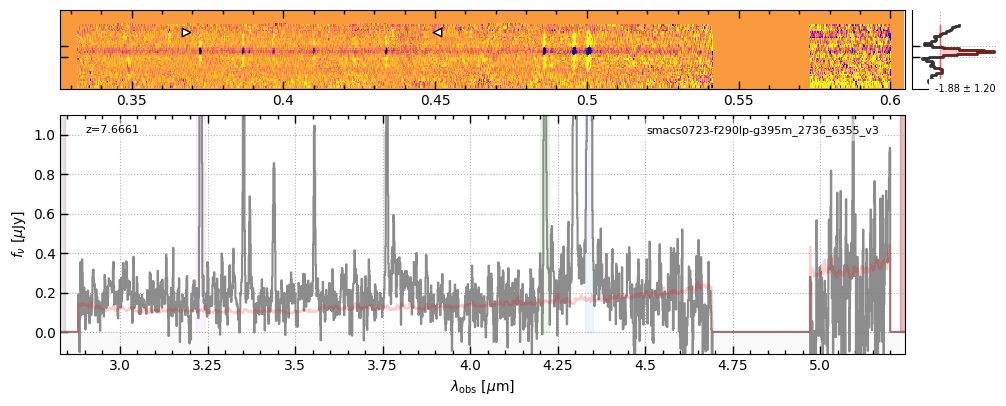

In [20]:
reload(msaexp.utils)
for g in hdus:
    #output_root = f'smacs0723-{g}_{key}_v3'
    output_root = f'smacs0723-{g}_{key}_v3'
    
    hdul = hdus[g]
    fig = msaexp.utils.drizzled_hdu_figure(hdul, output_root=output_root, z=7.6661, ny=None, ymax=1.1)

    fig.savefig(f'{output_root}.pdf')


In [21]:
# Drizzle combinations
key = '2736_10612'

hdus = {}
for g in gratings:
    slits = []
    for pipe in gratings[g]:
        _slits = pipe.get_background_slits(key)
        if _slits is not None:
            slits.extend(_slits)
            
    print(g, len(slits))
    
    output_root = f'smacs0723-{g}_{key}_v3'

    hdus[g] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                        profile_slice=slice(int(200*scale), int(900*scale)),
                                        standard_waves=scale,
                                        outlier_threshold=10,
                                        output_root=output_root,
                                        fit_prf=True, prf_center=None, prf_sigma=0.95, fix_sigma=True)


f290lp-g395m 12
build_regular_wavelength_wcs: Set user-defined wavelength grid (size=2020)
Pad 2 pixels on 2D cutout


2023-01-31 16:55:51,790 - stpipe - INFO - Driz parameter kernal: square
2023-01-31 16:55:51,791 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-01-31 16:55:51,792 - stpipe - INFO - Driz parameter fillval: 0
2023-01-31 16:55:51,799 - stpipe - INFO - Driz parameter weight_type: ivm
2023-01-31 16:55:52,193 - stpipe - INFO - Resampling science data
2023-01-31 16:55:52,244 - stpipe - INFO - Drizzling (34, 978) --> (43, 2020)
2023-01-31 16:55:52,262 - stpipe - INFO - Resampling var_rnoise
2023-01-31 16:55:52,368 - stpipe - INFO - Drizzling (34, 978) --> (43, 2020)
2023-01-31 16:55:52,399 - stpipe - INFO - Resampling var_poisson
2023-01-31 16:55:52,458 - stpipe - INFO - Drizzling (34, 978) --> (43, 2020)
2023-01-31 16:55:52,484 - stpipe - INFO - Resampling var_flat
2023-01-31 16:55:52,538 - stpipe - INFO - Drizzling (34, 978) --> (43, 2020)
2023-01-31 16:55:52,866 - stpipe - INFO - Resampling science data
2023-01-31 16:55:52,935 - stpipe - INFO - Drizzling (34, 978) --> (43, 2020)
2023-01-

Set prf_center: -2.5 (43, 2020) 13
fit_prf: center = -2.50. sigma = 0.95


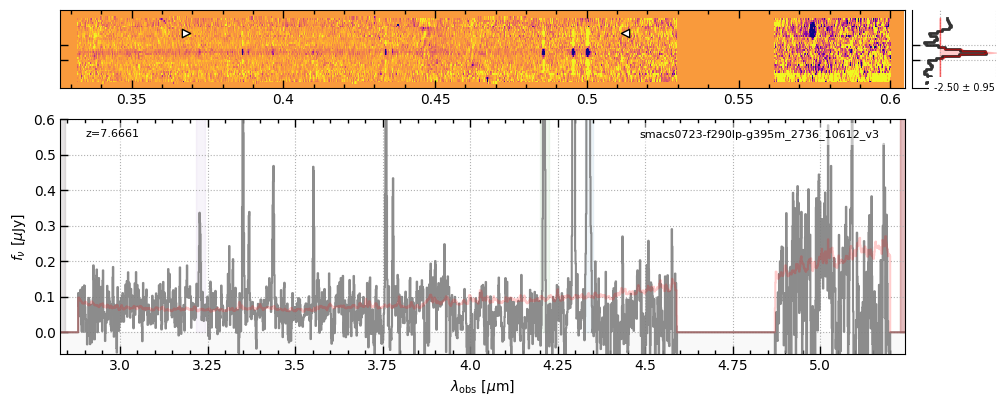

In [22]:
reload(msaexp.utils)
for g in hdus:
    output_root = f'smacs0723-{g}_{key}_v3'
    hdul = hdus[g]
    fig = msaexp.utils.drizzled_hdu_figure(hdul, output_root=output_root, z=7.6661, ny=None, ymax=0.6)


    fig.savefig(f'{output_root}.pdf')


In [23]:
output_root = f'smacs0723-v3-{g}_{key}'
hdus[g].writeto(f'{output_root}.spec.fits', overwrite=True)
print(output_root)

smacs0723-v3-f290lp-g395m_2736_10612


## Fit redshift

In [25]:
from msaexp import spectrum
spectrum.SCALE_UNCERTAINTY = 1.0

357it [00:05, 68.44it/s]
501it [00:07, 64.96it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-v3-f290lp-g395m_2736_10612.spec.fits
# z = 7.65951
# Tue Jan 31 16:56:23 2023
             line Hb      160.5 ±      4.9
             line Hg       87.2 ±      4.5
             line Hd       40.5 ±      4.5
             line H7       28.8 ±      6.7
             line H8       -5.7 ±     33.1
             line H9       15.2 ±      5.1
            line H10        7.0 ±      5.1
            line H11        6.7 ±      5.0
            line H12       -2.7 ±      5.2
      line OIII-4959      390.0 ±      6.0
      line OIII-5007     1153.5 ±     11.6
      line OIII-4363       34.3 ±      4.3
            line OII       40.2 ±      6.0
      line HeII-4687        3.0 ±      4.5
     line NeIII-3867       94.0 ±      5.3
       line HeI-3889       37.6 ±     33.1
     line NeIII-3968       26.5 ±      6.4
       line HeI-5877       40.9 ±      7.4
       line NeV-3346        1.3 ±      9.3
      line NeVI-3426        1.6 ±      7.1


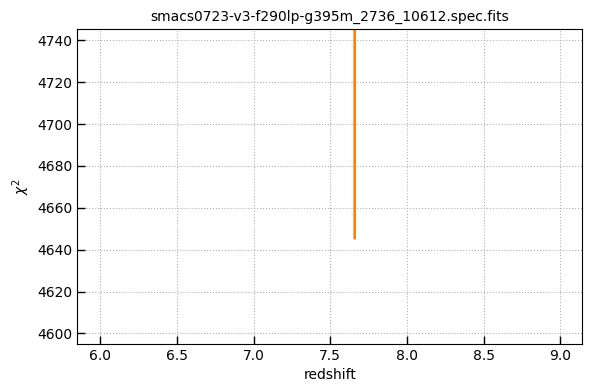

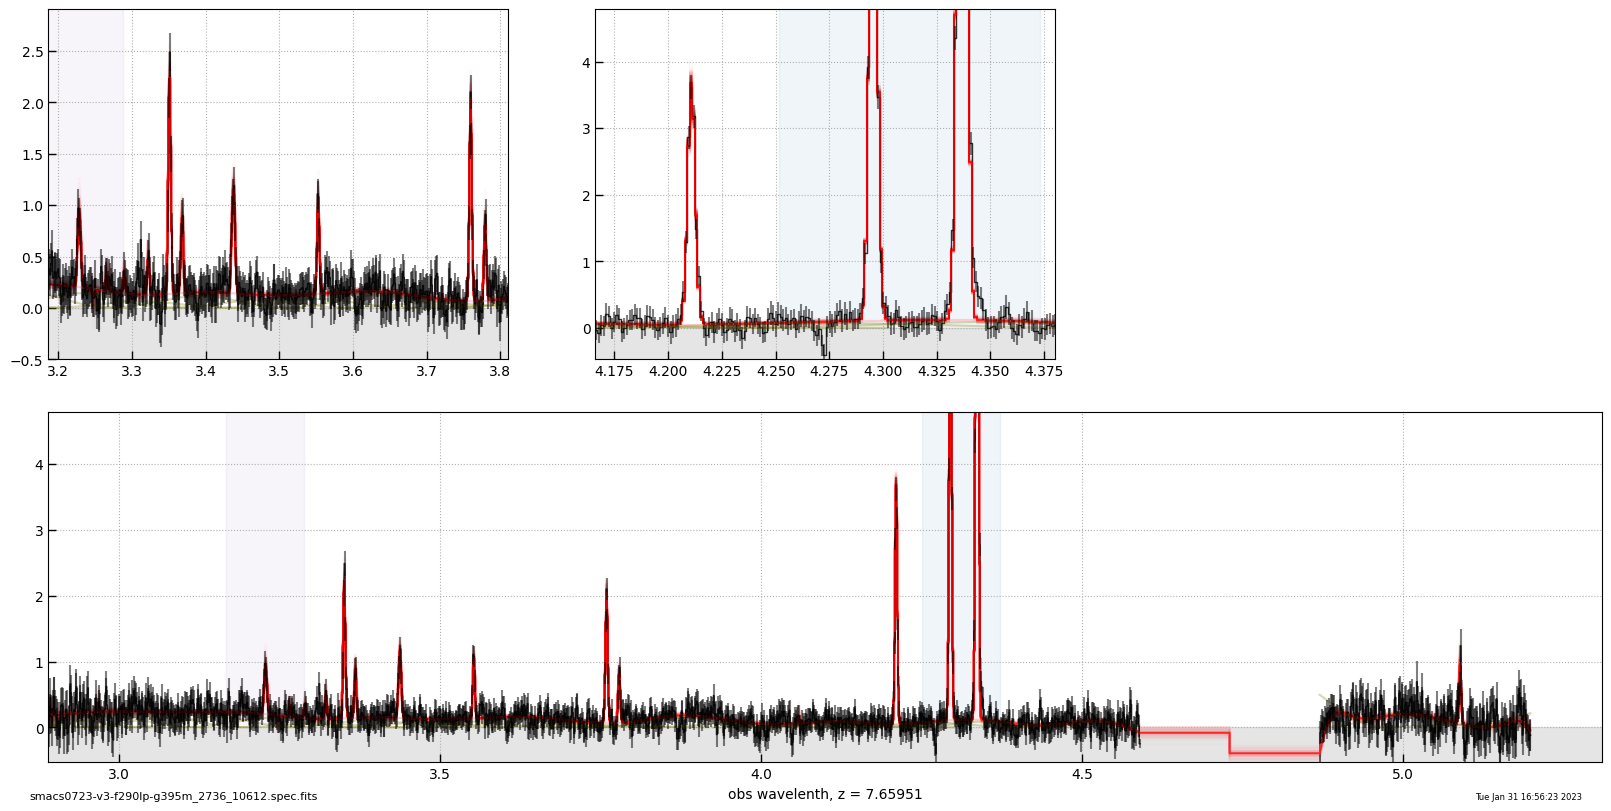

In [26]:

_ = spectrum.fit_redshift(file=f'{output_root}.spec.fits',
                          z0=[6,9], 
                          eazy_templates=None,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=20.,
                          is_prism=False,
                         )

Set SCALE_UNCERTAINTY:  [-0.09134965  1.12040556 -4.43896121  5.52119618]

# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-v3-f290lp-g395m_2736_10612.spec.fits
# z = 7.65951
# Tue Jan 31 16:56:25 2023
             line Hb      160.3 ±      3.7
             line Hg       87.2 ±      3.0
             line Hd       40.5 ±      2.8
             line H7       28.8 ±      4.1
             line H8       -5.7 ±     20.4
             line H9       15.2 ±      3.2
            line H10        7.0 ±      3.1
            line H11        6.7 ±      3.1
            line H12       -2.7 ±      3.2
      line OIII-4959      390.0 ±      4.6
      line OIII-5007     1153.4 ±      9.1
      line OIII-4363       34.2 ±      2.9
            line OII       40.2 ±      3.7
      line HeII-4687        3.1 ±      3.2
     line NeIII-3867       94.0 ±      3.3
       line HeI-3889       37.6 ±     20.4
     line NeIII-3968       26.5 ±      4.0
       line HeI-5877       40.9 ±      6.0
       line NeV-334

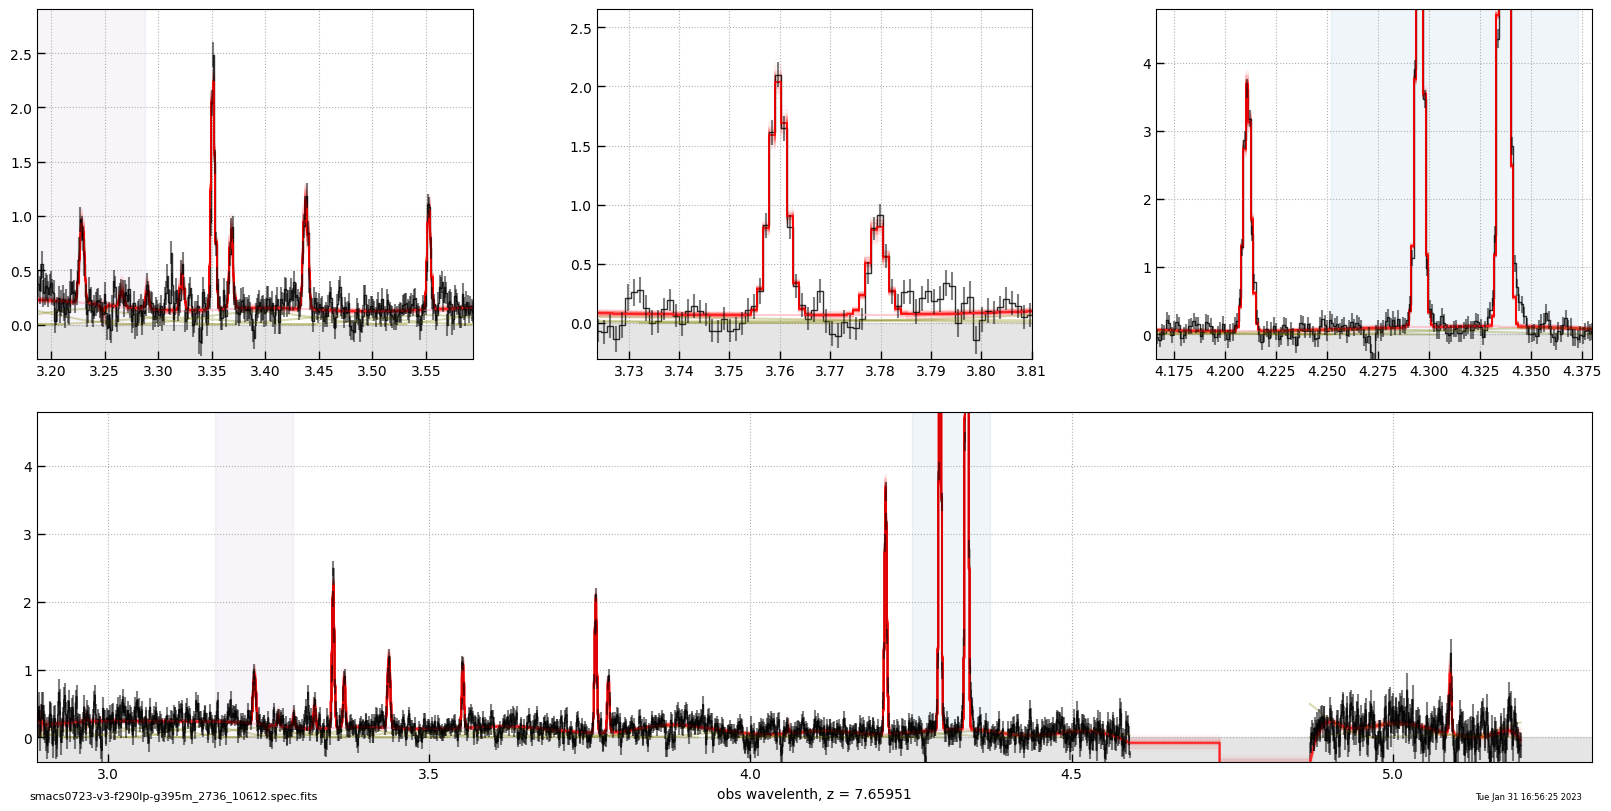

In [27]:
# Rescale uncertainties
_ = spectrum.plot_spectrum(file=f'{output_root}.spec.fits', z0=[6,9], 
                           z=_[1]['z'],
                          eazy_templates=None,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=10.,
                          is_prism=False,
                           scale_uncertainty_kwargs={'order':3},
                           use_full_dispersion=False,
                           Rline=5000,
                           ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )

357it [00:05, 69.55it/s]
501it [00:07, 67.40it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-v3-f290lp-g395m_2736_10612.spec.fits
# z = 7.65985
# Tue Jan 31 16:56:38 2023
             line Hb      159.0 ±      3.8
             line Hg       86.6 ±      3.0
             line Hd       40.3 ±      2.8
             line H7       26.0 ±      4.2
             line H8      -19.4 ±     20.5
             line H9       15.2 ±      3.1
            line H10        7.1 ±      3.1
            line H11        6.7 ±      3.1
            line H12       -2.7 ±      3.2
      line OIII-4959      386.7 ±      5.2
      line OIII-5007     1135.6 ±     10.8
      line OIII-4363       34.5 ±      2.9
            line OII       39.8 ±      3.7
      line HeII-4687        2.6 ±      3.2
     line NeIII-3867       93.5 ±      3.4
       line HeI-3889       51.1 ±     20.5
     line NeIII-3968       29.2 ±      4.0
       line HeI-5877       41.3 ±      6.0
       line NeV-3346        1.3 ±      6.5
      line NeVI-3426        1.8 ±      4.7


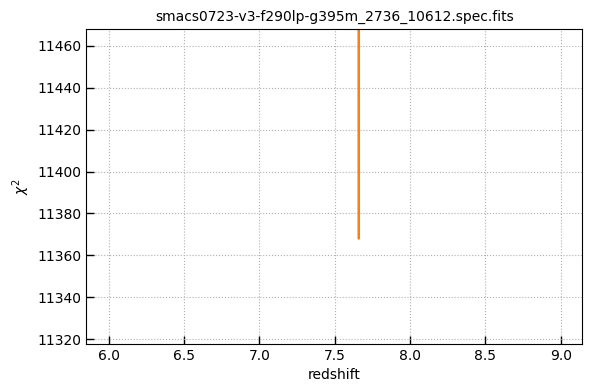

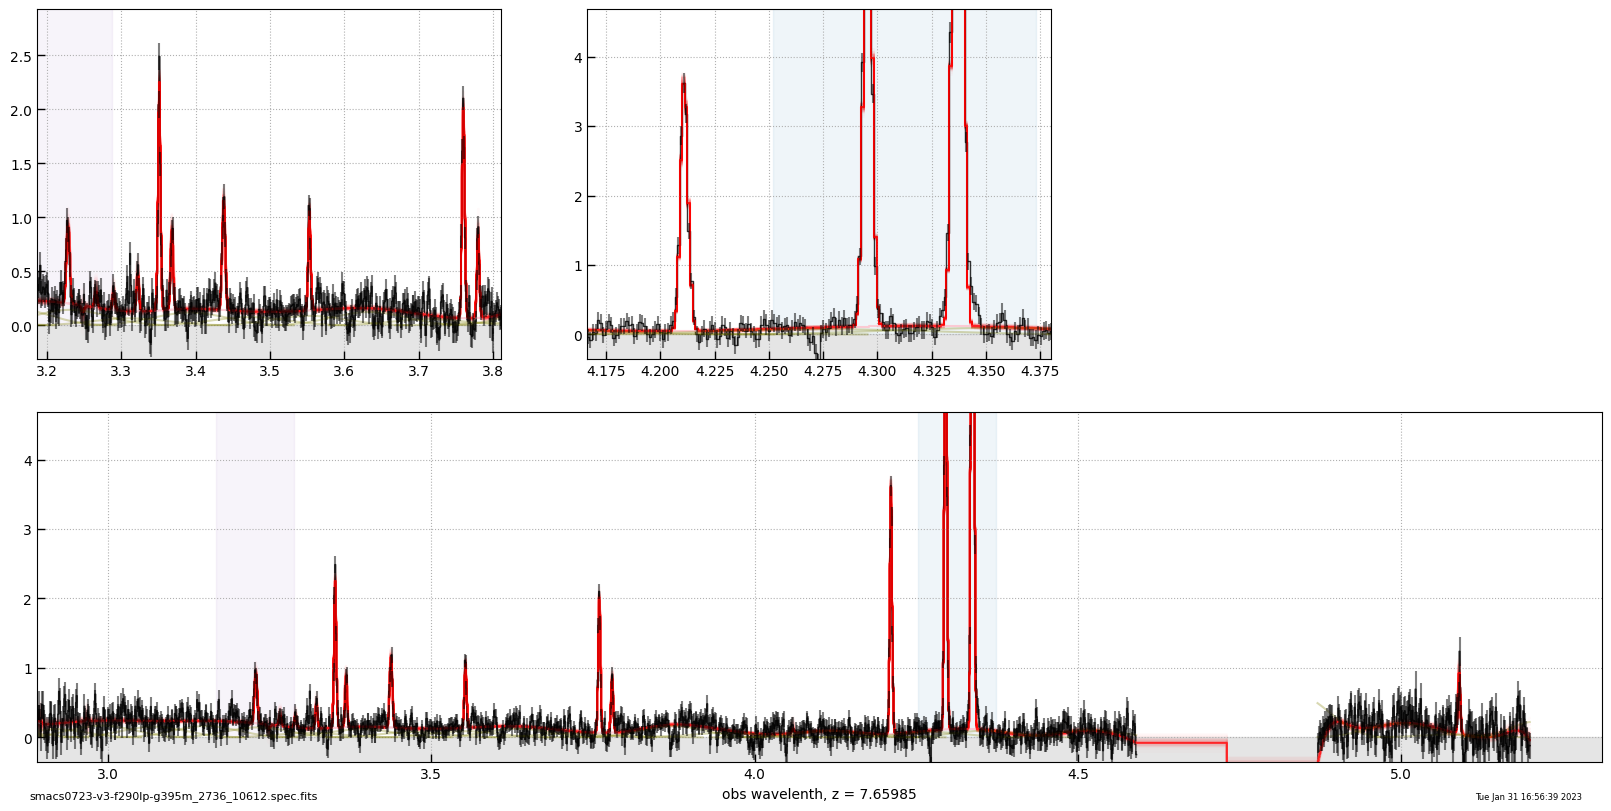

In [28]:
# Refit redshift with scaled uncertainties
_ = spectrum.fit_redshift(file=f'{output_root}.spec.fits', z0=[6,9], 
                          eazy_templates=None,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=10.,
                          is_prism=False,
                          use_full_dispersion=False
                         )

## Fit redshifts with `eazy` templates

In [29]:
import eazy
reload(eazy)

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()
    
templ = eazy.templates.read_templates_file('templates/sfhz/blue_sfhz_13.param')


2023-01-31 16:56:40,441 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/eazy/templates.py:356: ResourceWarning: unclosed file <_io.TextIOWrapper name='templates/sfhz/blue_sfhz_13.param' mode='r' encoding='UTF-8'>
  lines = open(templates_file).readlines()



In [30]:
spectrum.FFTSMOOTH = True

357it [00:01, 187.27it/s]
501it [00:03, 161.44it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-v3-f290lp-g395m_2736_10612.spec.fits
# z = 7.65933
# Tue Jan 31 16:56:45 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-v3-f290lp-g395m_2736_10612.spec.fits
# z = 7.65933
# Tue Jan 31 16:56:46 2023
             line Hb      160.6 ±      3.8
             line Hg       87.3 ±      3.0
             line Hd       40.4 ±      2.8
             line H7       30.1 ±      4.1
             line H8        0.9 ±     20.5
             line H9       15.2 ±      3.2
            line H10        6.9 ±      3.1
            line H11        6.7 ±      3.1
            line H12       -2.7 ±      3.2
      line OIII-4959      388.9 ±      5.2
      line OIII-5007     1147.6 ±     10.9
      line OIII-4363       33.9 ±      2.9
            line OII       40.4 ±      3.7
      line HeII-4687        3.3 ±      3.2
     line NeIII-3867       93.6 ±      3.4
       line HeI-3889       31.1 ±     20.5
     line NeIII-3968       25.2 ±      4.0
   

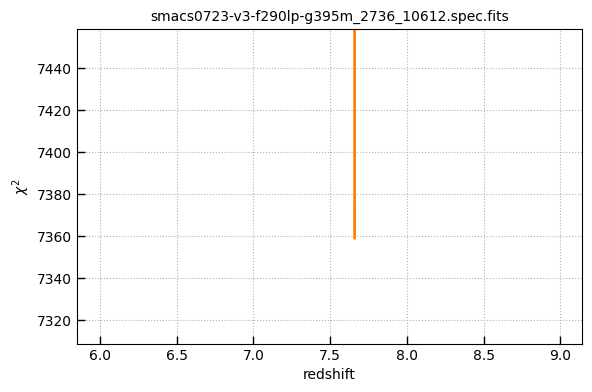

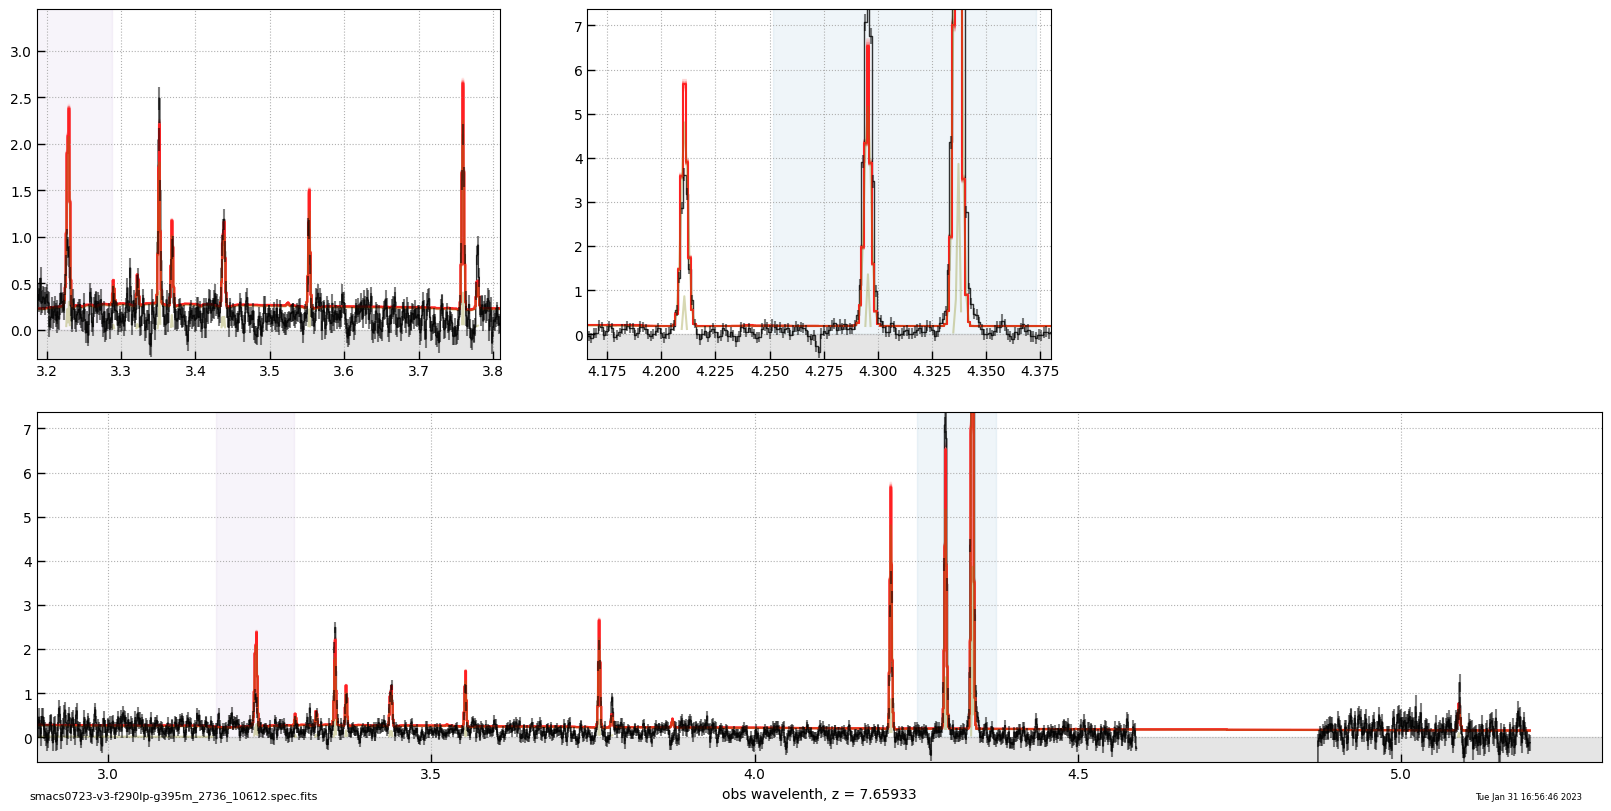

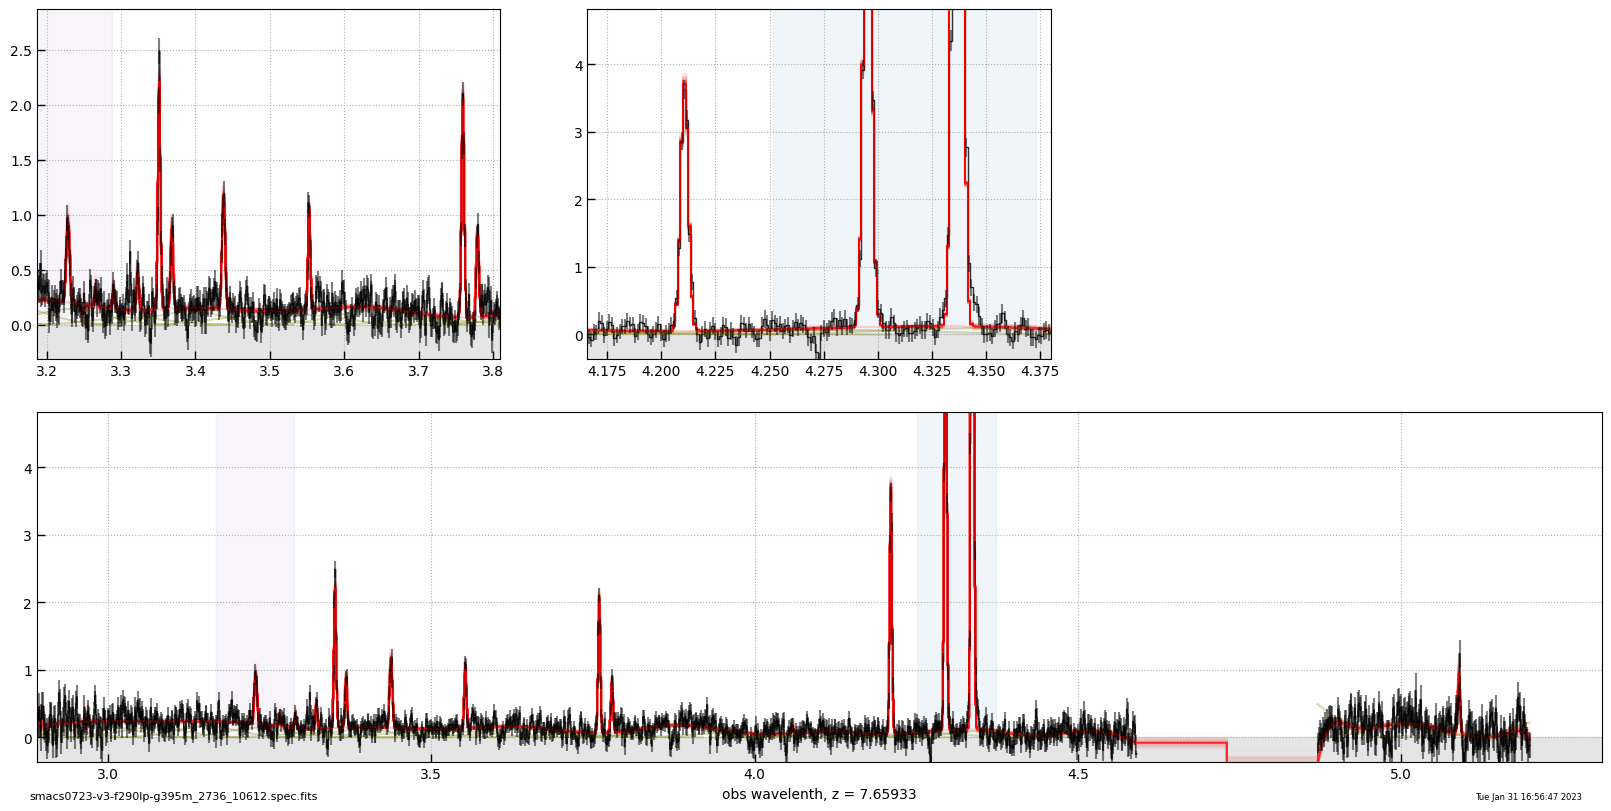

In [31]:
_ = spectrum.fit_redshift(file=f'{output_root}.spec.fits', z0=[6,9], 
                          eazy_templates=templ,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=10.,
                          is_prism=False,
                          use_full_dispersion=False,
                         )

## More sources

f290lp-g395m 12
build_regular_wavelength_wcs: Set user-defined wavelength grid (size=2020)
Pad 2 pixels on 2D cutout


2023-01-31 16:57:12,364 - stpipe - INFO - Driz parameter kernal: square
2023-01-31 16:57:12,364 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-01-31 16:57:12,364 - stpipe - INFO - Driz parameter fillval: 0
2023-01-31 16:57:12,364 - stpipe - INFO - Driz parameter weight_type: ivm
2023-01-31 16:57:12,753 - stpipe - INFO - Resampling science data
2023-01-31 16:57:12,776 - stpipe - INFO - Drizzling (39, 89) --> (53, 2020)
2023-01-31 16:57:12,777 - stpipe - INFO - Resampling var_rnoise
2023-01-31 16:57:12,802 - stpipe - INFO - Drizzling (39, 89) --> (53, 2020)
2023-01-31 16:57:12,804 - stpipe - INFO - Resampling var_poisson
2023-01-31 16:57:12,827 - stpipe - INFO - Drizzling (39, 89) --> (53, 2020)
2023-01-31 16:57:12,830 - stpipe - INFO - Resampling var_flat
2023-01-31 16:57:12,853 - stpipe - INFO - Drizzling (39, 89) --> (53, 2020)
2023-01-31 16:57:13,077 - stpipe - INFO - Resampling science data
2023-01-31 16:57:13,099 - stpipe - INFO - Drizzling (39, 89) --> (53, 2020)
2023-01-31 16

Set prf_center: -3.5 (53, 2020) 12
fit_prf: center = -3.31. sigma = 2.00


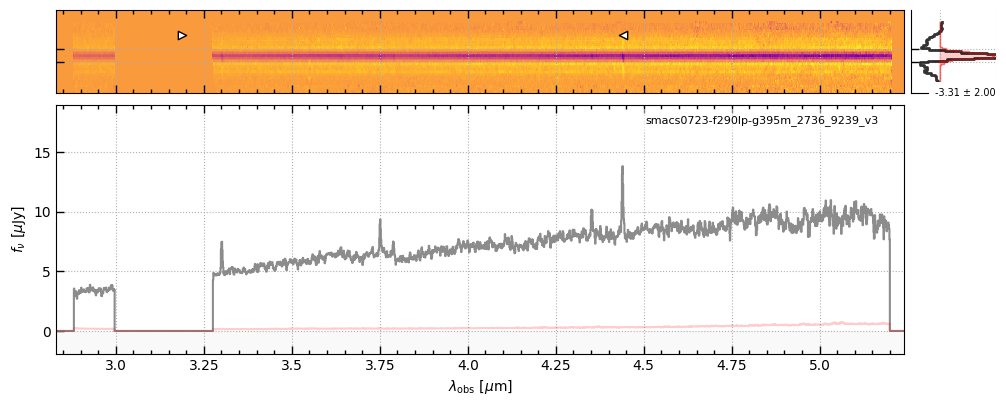

In [32]:
key = pipe.targets[0]

key = '2736_9239'

hdus = {}
for g in gratings:
    slits = []
    for pipe in gratings[g]:
        _slits = pipe.get_background_slits(key)
        if _slits is not None:
            slits.extend(_slits)
            
    print(g, len(slits))
    
    output_root = f'smacs0723-{g}_{key}_v3'

    hdus[g] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                        profile_slice=slice(int(200*scale), int(900*scale)),
                                        standard_waves=scale,
                                        outlier_threshold=10,
                                        output_root=output_root,
                                        fit_prf=True, prf_center=None, prf_sigma=1.1, center_limit=8)

    
    fig = msaexp.utils.drizzled_hdu_figure(hdus[g], output_root=output_root, ny=None)


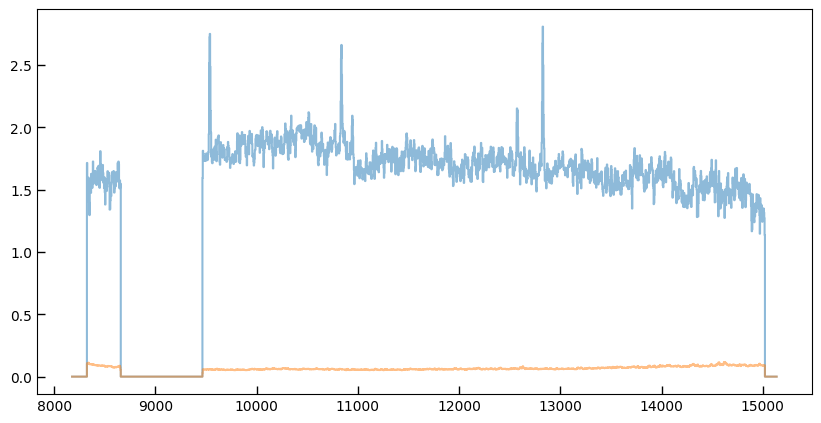

In [33]:
import grizli.utils

fig, ax = plt.subplots(1,1,figsize=(10,5))

z = 2.272e4/6564.-1

for g in hdus:
    sp = grizli.utils.GTable(hdus[g]['SPEC1D'].data)
    ax.step(sp['wave']/(1+z)*1.e4, sp['flux']*(sp['wave']/2.)**-2, alpha=0.5, where='mid')
    ax.step(sp['wave']/(1+z)*1.e4, sp['err']*(sp['wave']/2.)**-2, alpha=0.5, where='mid')
    
#ax.set_xlim(2.25, 2.3)
# ax.set_xlim(9000, 1.4e4)

f290lp-g395m 8
build_regular_wavelength_wcs: Set user-defined wavelength grid (size=2020)
Pad 2 pixels on 2D cutout


2023-01-31 16:57:20,452 - stpipe - INFO - Driz parameter kernal: square
2023-01-31 16:57:20,455 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-01-31 16:57:20,460 - stpipe - INFO - Driz parameter fillval: 0
2023-01-31 16:57:20,461 - stpipe - INFO - Driz parameter weight_type: ivm
2023-01-31 16:57:20,852 - stpipe - INFO - Resampling science data
2023-01-31 16:57:20,898 - stpipe - INFO - Drizzling (39, 988) --> (53, 2020)
2023-01-31 16:57:20,924 - stpipe - INFO - Resampling var_rnoise
2023-01-31 16:57:21,002 - stpipe - INFO - Drizzling (39, 988) --> (53, 2020)
2023-01-31 16:57:21,020 - stpipe - INFO - Resampling var_poisson
2023-01-31 16:57:21,102 - stpipe - INFO - Drizzling (39, 988) --> (53, 2020)
2023-01-31 16:57:21,122 - stpipe - INFO - Resampling var_flat
2023-01-31 16:57:21,188 - stpipe - INFO - Drizzling (39, 988) --> (53, 2020)
2023-01-31 16:57:21,502 - stpipe - INFO - Resampling science data
2023-01-31 16:57:21,558 - stpipe - INFO - Drizzling (39, 988) --> (53, 2020)
2023-01-

Set prf_center: -2.5 (53, 2020) 15
fit_prf: center = -2.20. sigma = 1.38


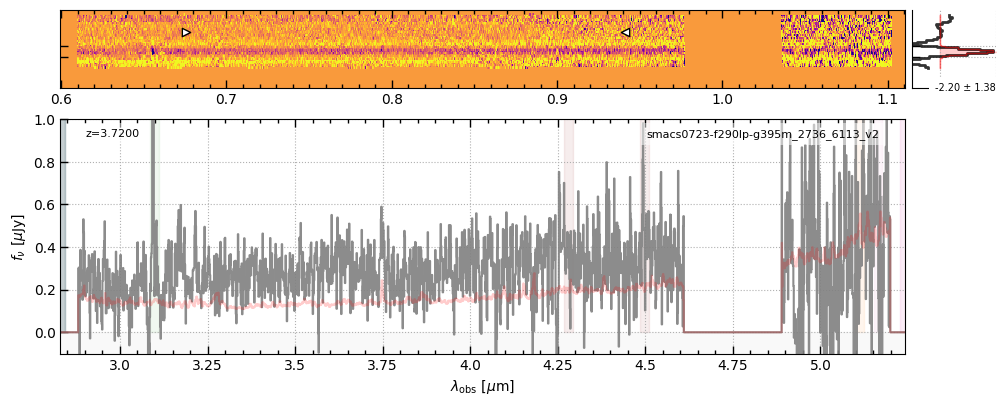

In [34]:
# Extract another object caught at the bottom of the slit (has ID 10511)
reload(msaexp.utils)

key = '2736_6113'

hdus = {}
for g in gratings:
    slits = []
    for pipe in gratings[g]:
        _slits = pipe.get_background_slits(key)
        if _slits is not None:
            slits.extend(_slits)
            
    print(g, len(slits))
    
    output_root = f'smacs0723-{g}_{key}_v2'

    hdus[g] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                        profile_slice=slice(int(200*scale), int(900*scale)),
                                        standard_waves=scale,
                                        outlier_threshold=10,
                                        output_root=output_root,
                                        fit_prf=True, prf_center=None, prf_sigma=1.1, center_limit=12)

    
    fig = msaexp.utils.drizzled_hdu_figure(hdus[g], output_root=output_root, ny=None, ymax=1, z=3.72)
    fig.savefig(f'{output_root}.pdf')


In [ ]:
break

In [ ]:
# carnall et al. and new redshifts
redshifts = {'2736_9922': 2.743,
             '2736_5144': 6.383,
             '2736_1917': 1.244,
             '2736_3772': 2.67e4/1.875e4-1, 
             '2736_4580': 3.09e4/5008.-1, # ?
             '2736_5735': 3.21e4/1.282e4-1,
             '2736_6113': 3.715,
             '2736_6355': 7.665,
             '2736_8140': 5.275,
             '2736_8506': 2.213,
             '2736_9236': 2.463,
             '2736_9483': 1.163,
             '2736_9721': 2.047e4/6564.-1,
             '2736_9922': 2.743,
             '2736_10612': 7.663,
             '2736_3042': 1.96e4/6564.-1,

             }

In [ ]:
# Looking at individual sources
ik = -1
targets

In [ ]:
key = targets[-1]
key = '2736_3042'

key = '2736_9922'
key = '2736_5144'
key = '2736_4798'
# key = '2736_4590'

#ik -= 3

ik += 1
key = targets[ik]

yoffset = 0.0
skip = []

for g in gratings:
    for pipe in gratings[g]:
        print(pipe.mode, key)
        if key == '2736_1370':
            yoffset = -4.0
            
        if key == '2736_8717':
            if '07001' in pipe.mode:
                skip = [0,1]
            else:
                skip = [0]
                
#         elif key == '2736_8506':
#             skip = [0]
            
#         elif key == '2736_8498':
#             yoffset = -12
            
#         if '07001' in pipe.mode:
#             skip = [0] # [0,1]
#             else:
#                 skip = [0]
                
#         elif key == '2736_3042':
#             yoffset = -14
#             skip = []
            
#         else:
#             skip = []
            
        try:
            _ = pipe.extract_spectrum(key, yoffset=yoffset, fit_profile_params=None, skip=skip)        
        except:
            plt.close('all')

In [ ]:
reload(msaexp.utils)

hdus = {}
for g in gratings:
    slits = []
    for pipe in gratings[g]:
        #_slits = pipe.get_background_slits(key, step='phot', check_background=False)
        _slits = pipe.get_background_slits(key) #, step='phot', check_background=False)
        if _slits is not None:
            slits.extend(_slits)
            
    print(g, len(slits))
    
    output_root = f'smacs0723-{g}_{key}_v3'

    hdus[output_root] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                        profile_slice=slice(int(200*scale), int(600*scale)),
                                        standard_waves=scale,
                                        outlier_threshold=10,
                                        output_root=output_root,
                                        fit_prf=False, prf_center=-0.4, prf_sigma=1.0, fix_sigma=True,
                                        #fit_prf=True, prf_center=-8., prf_sigma=1.0, fix_sigma=False,
                                        #fit_prf=True, prf_center=None, prf_sigma=1.0, fix_sigma=False,
                                                         center_limit=5)

    
    if key in redshifts:
        z = redshifts[key]
    else:
        z = None
    #z = 1.96e4/6564.-1

    fig = msaexp.utils.drizzled_hdu_figure(hdus[output_root], output_root=output_root, ny=None, z=z)


In [ ]:
z=3.21e4/1.282e4-1
z = 3.72
z = 2.047e4/6564.-1
z = 1.96e4/6564.-1

fig = msaexp.utils.drizzled_hdu_figure(hdus[output_root], output_root=output_root, ny=None, z=z)


In [ ]:
import grizli.utils

fig, ax = plt.subplots(1,1,figsize=(10,5))

if z is None:
    zi = 0.
else:
    zi = z

# zi = 3.715
    
for g in hdus:
    sp = grizli.utils.GTable(hdus[g]['SPEC1D'].data)
    ax.step(sp['wave']/(1+zi)*1.e4, sp['flux']*(sp['wave']/2.)**-2, alpha=0.5, where='mid')
    ax.step(sp['wave']/(1+zi)*1.e4, sp['err']*(sp['wave']/2.)**-2, alpha=0.5, where='mid')
    
#ax.set_xlim(2.25, 2.3)
# ax.set_xlim(9000, 1.4e4)
# ax.set_xlim(3600, 4400); ax.set_ylim(-0.05, 0.5)
# ax.set_xlim(4500, 8800); ax.set_ylim(-0.05, 1.5)
#ax.set_xlim(9000, 9800); ax.set_ylim(-0.05, 0.5)
#ax.set_xlim(9000, 18000); ax.set_ylim(-0.05, 0.5)


## Save any updates to the slit logs

In [ ]:
for g in gratings:
    for pipe in gratings[g]:
        pipe.parse_slit_info()

## Slit regions

In [ ]:
for k in pipe.slitlets:
    sd = pipe.slitlets[k]
    dr = (sd['source_ra'] - sd['slit_ra'])*np.cos(sd['source_dec']/180*np.pi)*3600
    dd = (sd['source_dec'] - sd['slit_dec'])*3600
    
    plt.scatter(dr, dd, alpha=0.1)
    

In [ ]:
from tqdm import tqdm
reload(msaexp.utils)

self = gratings[g][0]

slit_key = self.last_step
pipe = self.pipe[slit_key]

regs = []
for j in range(self.N):
    regs.append([])

include_yoffset = False

for key in tqdm(self.slitlets):
    slitlet = self.slitlets[key]
    #slitlet['bkg_index'], slitlet['src_index'], slitlet['slit_index']

    i = self.slit_index(key) # slitlet['slit_index']

    yoffset = slitlet['yoffset']

    dr = slitlet['source_ra'] - slitlet['slit_ra']
    dd = slitlet['source_dec'] - slitlet['slit_dec']

    for j in range(self.N):
        _slit = pipe[j].slits[i]
        _wcs = _slit.meta.wcs
        sh = _slit.data.shape
        
        rc, dc = msaexp.utils.get_slit_corners(_slit)
        
        xy = np.array([rc+dr, dc+dd])
        
        sr = grizli.utils.SRegion(xy)
        _name = slitlet['source_name']

        if '_m' in _name:
            sr.ds9_properties = 'color=yellow'
        elif 'b' in _name:
            sr.ds9_properties = 'color=white'
        else:
            sr.ds9_properties = 'color=green'

        if j == 0:
            sr.label = _name
            sr.ds9_properties += ' width=2'

        regs[j].append(sr)

_slitreg = f'{self.mode}.slits.reg'
print(_slitreg)
with open(_slitreg, 'w') as fp:
    for j in range(self.N):
            fp.write('icrs\n')
            for sr in regs[j]:
                fp.write(sr.region[0]+'\n')


In [ ]:
slit = slits[0]

In [ ]:
from gwcs import wcstools
for slit in slits:
    sh = slit.data.shape

    _wcs = slit.meta.wcs

    s2d = _wcs.get_transform('slit_frame', 'detector')
    d2s = _wcs.get_transform('detector', 'slit_frame')
    s2w = _wcs.get_transform('slit_frame', 'world')
    d2w = _wcs.get_transform('detector', 'world')

    bbox = _wcs.bounding_box
    grid = wcstools.grid_from_bounding_box(bbox)
    _, sy, slam = np.array(d2s(*grid))

    smi = np.nanmin(sy)
    sma = np.nanmax(sy)

    slit_x = np.array([-0.5, 0.5, 0.5, -0.5])
    slit_y = np.array([smi, smi, sma, sma])

    ra_corner, dec_corner, _w = s2w(slit_x, slit_y, np.nanmedian(slam))

    plt.plot(ra_corner, dec_corner)
    plt.scatter(slit.source_ra, slit.source_dec, marker='x')

In [ ]:
np.median(slam)